In [1]:
import pandas as pd
import torchvision.transforms as T
import torch

from dataset import SteelDataset

df = pd.read_csv("../data/train.csv")
transform = T.Compose([T.ToTensor()])
dataset = SteelDataset(df, "../data/train_images", transform)
print(len(dataset))

12568


缺陷数据的分析

In [3]:
# 分析每个种类的缺陷出现次数
import numpy as np
import matplotlib.pyplot as plt

# 查看数据集的基本信息
print(f"数据集大小: {len(dataset)}")
print(f"缺陷数量: {df.shape[0]}")
df.head()

数据集大小: 12568
缺陷数量: 7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
# 计算每个ClassId的出现次数
class_counts = df['ClassId'].value_counts().sort_index()
print("每个类别的缺陷数量:")
print(class_counts)

每个类别的缺陷数量:
ClassId
1     897
2     247
3    5150
4     801
Name: count, dtype: int64


In [5]:
# 统计每张图像中包含的缺陷类型
# 创建一个字典来统计每个图像中出现的缺陷类型
image_defect_counts = {}
for name in dataset.image_names:
    defect_types = []
    for cls in range(1, 5):
        has_defect = df[(df['ImageId'] == name) & (df['ClassId'] == cls)]['EncodedPixels'].notna().any()
        if has_defect:
            defect_types.append(cls)
    image_defect_counts[name] = defect_types

# 统计每张图像中的缺陷类型数量分布
defect_count_distribution = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
for defects in image_defect_counts.values():
    count = len(defects)
    if count in defect_count_distribution:
        defect_count_distribution[count] += 1
    else:
        defect_count_distribution[count] = 1

print("每张图像中缺陷类型数量的分布:")
for count, num_images in defect_count_distribution.items():
    print(f"{count}种缺陷: {num_images}张图像")

每张图像中缺陷类型数量的分布:
0种缺陷: 5902张图像
1种缺陷: 6239张图像
2种缺陷: 425张图像
3种缺陷: 2张图像
4种缺陷: 0张图像


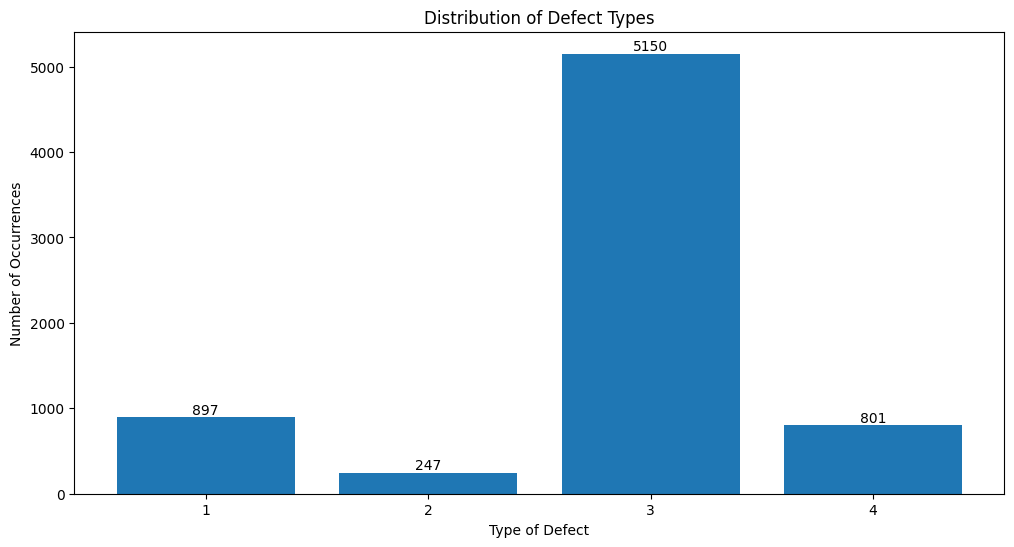

In [6]:
# 可视化每个缺陷类别的出现次数
plt.figure(figsize=(12, 6))

bars = plt.bar(class_counts.index, class_counts.values)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Type of Defect')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Defect Types')
plt.xticks(class_counts.index)

plt.show()

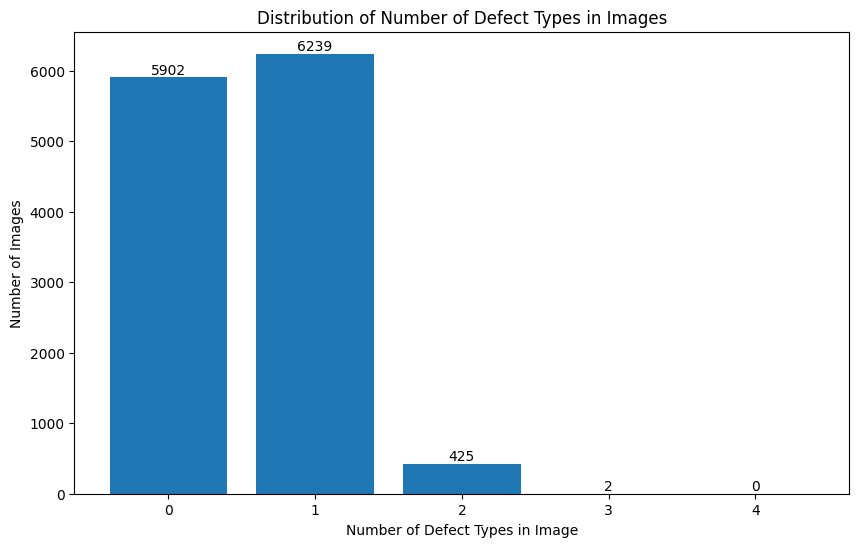

In [7]:
# 可视化每张图像中缺陷类型数量的分布
plt.figure(figsize=(10, 6))

counts = list(defect_count_distribution.keys())
values = list(defect_count_distribution.values())

bars = plt.bar(counts, values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Number of Defect Types in Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Number of Defect Types in Images')
plt.xticks(counts)

plt.show()

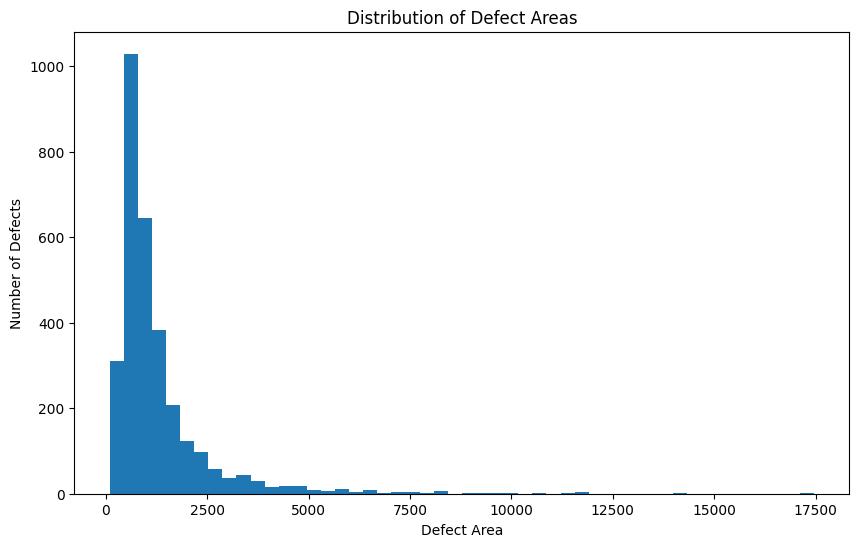

min area: 90
max area: 17467
mean area: 1269.347501622323


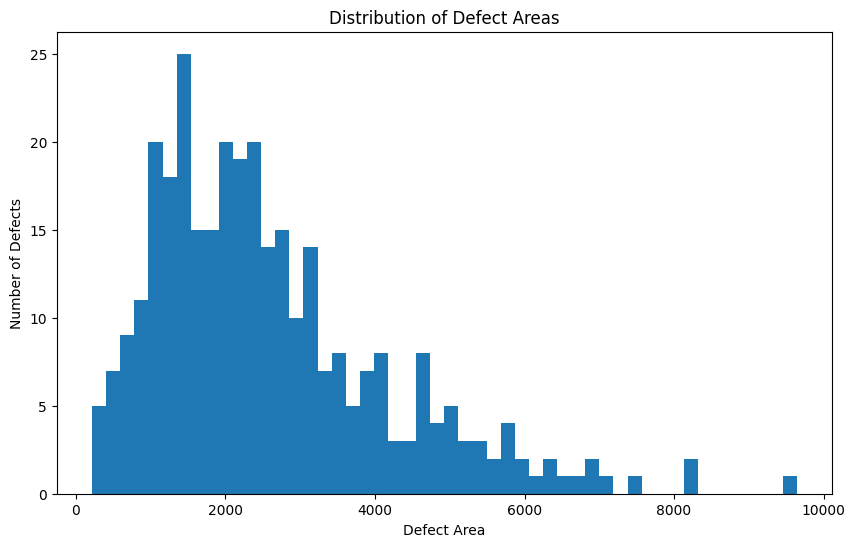

min area: 216
max area: 9641
mean area: 2599.5981308411215


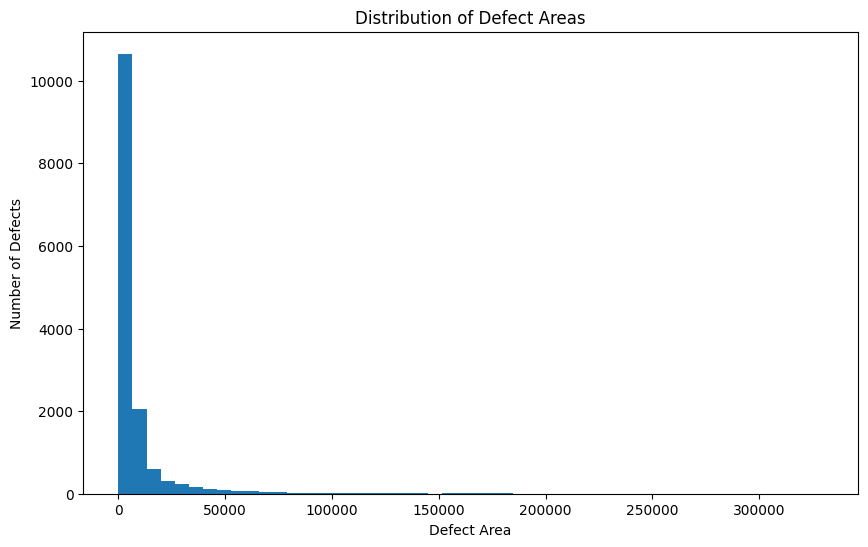

min area: 1
max area: 329859
mean area: 8964.152034407427


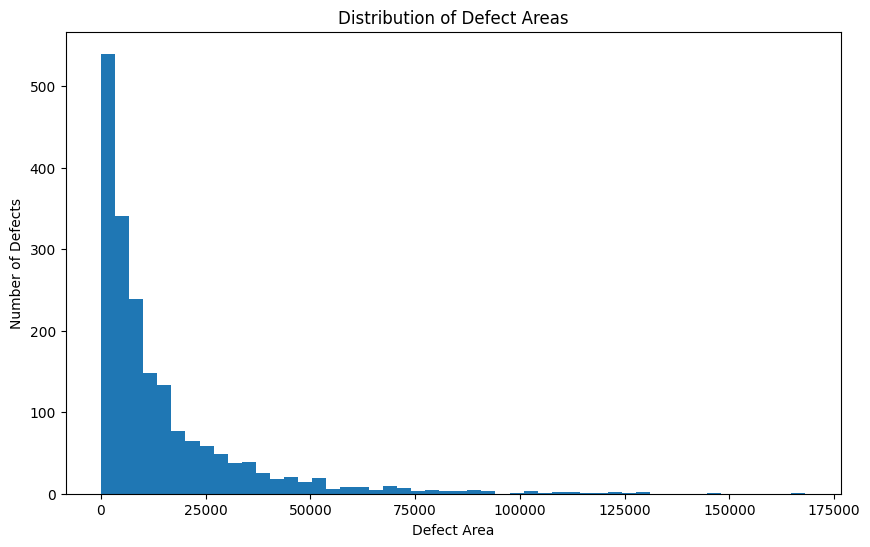

min area: 1
max area: 168151
mean area: 14438.160461457786


In [16]:
from scipy.ndimage import label

# 可视化每张图像中缺陷位置的面积

structure = np.ones((3, 3), dtype=np.int32)

for cls in range(0, 4):
    defect_areas = []
    for _, mask in dataset:
        labeled_mask, num_features = label(mask[cls], structure=structure)
        sizes = np.bincount(labeled_mask.ravel())[1:]  # 排除背景
        defect_areas.extend(sizes)

    plt.figure(figsize=(10, 6))
    plt.hist(defect_areas, bins=50)
    plt.xlabel('Defect Area')
    plt.ylabel('Number of Defects')
    plt.title('Distribution of Defect Areas')
    plt.show()

    print("min area:", np.min(defect_areas))
    print("max area:", np.max(defect_areas))
    print("mean area:", np.mean(defect_areas))
